In [1]:
import numpy as np
from astropy.table import Table, Column, vstack
from astropy.io import fits
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
from scipy.stats import powerlaw
from scipy import integrate
from scipy.special import gammaln
import time
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from scipy.optimize import minimize
from statsmodels.tsa.stattools import acf
%matplotlib inline

/Applications/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import bayes
import simdat
import auto_corr
arf_table = Table.read('/Users/mlazz/Dropbox/UW/PileupABC/13858/repro/SDSSJ091449.05+085321.corr.arf',format='fits')
arf = np.array(arf_table['ENERG_HI'])

In [3]:
def geom_dist(data1,data2):
    """
    Input data must be 1D numpy arrays
    """
    diff = np.fabs(data1-data2)
    return np.mean(diff)

### Generate "real data". Only do this once, write to file, and save.

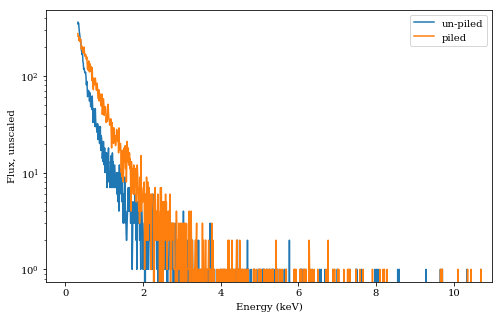

In [4]:
#Generate "real" data
energy_bins, energy_hist, piled_hist = simdat.simulate_data(50000,2.7,'cdf',arf)
simdat.plot_data(energy_bins, energy_hist, piled_hist)
real_data = Table([energy_bins,energy_hist,piled_hist],names=('Energy','Unpiled','Piled'))

In [5]:
!rm real_data.fits
!rm real_data.txt
real_data.write('real_data.fits')
real_data.write('real_data.txt',format='ascii')

### ABC work start here:

ABC Overview:
*****
PART I
*****
1. Generate data set with given A (stop, length of observation, which will determine the number of photons using the Chandra count rate, or assumed count rate?) and alpha
2. Generate more data with the same input parameters, but they will be random because of the Poisson distribution
3. Find some metrics to compare the fake data to the real data (distance metrics, look what they use in the systems biology paper)
4. Plot distribution of metrics, m_i, and the histogram should look like a Gaussian or something like that
*****
PART II
*****
5. Simulate data from prior (a bunch of random choices from the prior)
6. Compare sim to real data using the same distance metrics as in Part I
7. Plot distribution 
8. Where the distribution from the real data intersects the distribution from the prior, make that the cut off for "good" fits - this is the distance metric I will use in Part III
*****
PART III: rejection sampling
*****
9. Sampe from prior, create simulated data
10. Calculate m_i
11. if $m_{i}<m_{threshold}$ (determined in Part II), accept. otherwise reject.

### PART I

In [6]:
data = Table.read('real_data.fits')

In [7]:
#Only do this ONCE to generate data - otherwise, just read in part1_fake_data.txt in following cell
count=0
while count < 1000:
    if count%100 == 0:
        print(count)
    bins, nrgy, new_spectrum = simdat.simulate_data(50000,2.7,'cdf',arf)
    spec_col = Column(new_spectrum,name='simspec'+str(count))
    data.add_column(spec_col)
    count += 1

0
100
200
300
400
500
600


KeyboardInterrupt: 

In [8]:
data_part1 = Table.read('part1_fake_data.txt',format='ascii')

In [9]:
m = np.zeros(1000,dtype=float)
for i in range(len(m)):
    m[i] = geom_dist(np.array(data_part1['Piled']),np.array(data_part1['simspec'+str(i)]))

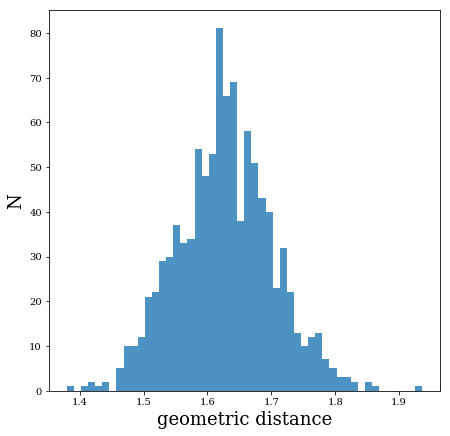

In [10]:
fig,ax = plt.subplots(figsize=(7,7))
ax.set_xlabel('geometric distance',fontsize=18)
ax.set_ylabel('N',fontsize=18)
#ax.axvline(0.0,color='r',linestyle='--',linewidth=3,alpha=0.5)
ax.hist(m,bins=50,alpha=0.8)
plt.savefig('abc_part1.pdf')

In [36]:
#data.write('part1_fake_data.fits')
data.write('part1_fake_data.txt',format='ascii')

### PART II

Priors: photon index between 0 and 5, observation time between 10,000 and 100,000 s

In [11]:
data = Table.read('real_data.fits')

In [12]:
data[:3]

Energy,Unpiled,Piled
float32,int64,int64
0.32,359,274
0.33,341,254
0.34,350,258


In [13]:
arf[:3]

array([ 0.31      ,  0.31999999,  0.33000001], dtype=float32)

In [4]:
N = 1000
phot_ind = np.random.uniform(0.5,5,N)
obs_time = np.random.randint(10000,100000,N)
for i in range(N):
    print i, obs_time[i],phot_ind[i]
    bins, nrgy, new_spectrum = simdat.simulate_data(obs_time[i],phot_ind[i],'cdf',arf)
    spec_col = Column(new_spectrum,name='simspec'+str(i))
    data.add_column(spec_col)

0 30338 1.3513343784
piled energy [  2.20323651e+02   0.00000000e+00   0.00000000e+00 ...,   1.05730270e-01
   3.92493997e-01   2.41241551e-01]
piled energy > 0 [  2.20323651e+02   2.76097215e+00   1.64887691e+05 ...,   1.05730270e-01
   3.92493997e-01   2.41241551e-01]
[88 91 94 ...,  1  1  1]
1 28029 2.58639926966
piled energy [ 1.60017648  0.          0.         ...,  0.          0.          0.11367759]
piled energy > 0 [ 1.60017648  0.11288594  0.24742109 ...,  0.29276819  0.88258188
  0.11367759]
[136 136 135 ...,   0   0   0]
2 34253 2.98171896894
piled energy [ 0.33198049  0.          0.         ...,  0.          0.          0.28360439]
piled energy > 0 [ 0.33198049  0.11922886  0.28033423 ...,  0.13733702  0.65157983
  0.28360439]
[154 179 166 ...,   0   0   0]
3 66141 2.38113768771
piled energy [ 0.10100829  0.78338236  0.         ...,  0.54026659  0.          0.17218633]
piled energy > 0 [ 0.10100829  0.78338236  0.11640242 ...,  0.11089434  0.54026659
  0.17218633]
[342 347 

simdat.py:51: RuntimeWarning: overflow encountered in power
  x = a*(1-r)**(-1/(gamma-1))


piled energy [  4.53296421e+91   0.00000000e+00   0.00000000e+00 ...,   1.01348923e+00
   1.86626944e+45   4.56665753e+55]
piled energy > 0 [  4.53296421e+091   7.21718120e+024   1.00306301e+104 ...,
   1.01348923e+000   1.86626944e+045   4.56665753e+055]
[19 16 10 ...,  0  1  0]
122 72426 2.76341521353
piled energy [ 0.54008444  0.          0.         ...,  0.398198    0.          0.1057257 ]
piled energy > 0 [ 0.54008444  0.16881988  0.13885743 ...,  0.10744541  0.398198    0.1057257 ]
[370 411 328 ...,   0   0   0]
123 63929 3.98558707668
piled energy [ 0.16925957  0.10798738  0.13237594 ...,  0.10035686  0.18909345
  0.16759626]
piled energy > 0 [ 0.16925957  0.10798738  0.13237594 ...,  0.10035686  0.18909345
  0.16759626]
[276 318 311 ...,   0   0   0]
124 50216 4.56871551588
piled energy [ 0.24126446  0.          0.21640264 ...,  0.11457777  0.12094241
  0.11367373]
piled energy > 0 [ 0.24126446  0.21640264  0.40076724 ...,  0.11457777  0.12094241
  0.11367373]
[211 247 271 ...,

In [14]:
data

Energy,Unpiled,Piled
float32,int64,int64
0.32,359,274
0.33,341,254
0.34,350,258
0.35,311,232
0.36,282,249
0.37,266,227
0.38,237,227
0.39,237,241
0.4,218,227


piled energy [  0.8389497    0.           0.           0.           0.11166381
   1.1588061    0.           0.           0.           0.           0.
   0.16469853   0.35535818   0.           0.           0.27349885
   0.33367839   0.           0.           0.36382632   0.42723134   0.
   0.10716926   0.15208102   0.21877486   0.65685272   0.           0.
   0.13353657   0.11398395   0.1527496    0.71839027   0.           0.
   0.11614086   0.14013547   0.12198481   0.5043561    0.           0.
   0.11883138   0.19536951   0.37655095   0.           0.10541439
   0.25573248   0.           0.1239306    0.81996906   0.           0.           0.
   0.           0.10157795   0.18683747   0.11639002   1.04123294   0.           0.
   0.           0.           0.21057317   0.20438042   0.21477462   0.
   0.13196567   0.23699814   0.18413452   1.0580916    0.           0.           0.
   0.           0.           0.20403585   0.10078118   0.1087272
   0.10922736   0.10203793   0.14567479   0.10

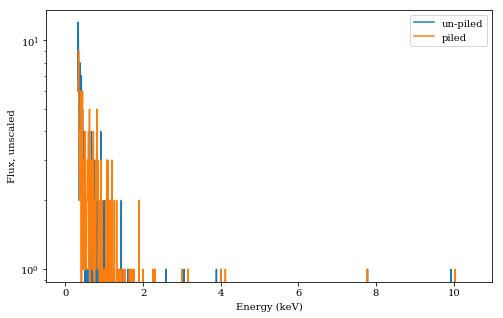

In [12]:
energy_bins, energy_hist, piled_hist = test_sim(1000,2.7,'cdf',arf)
simdat.plot_data(energy_bins, energy_hist, piled_hist)

In [15]:
data_part2 = Table.read('part2_fake_data.txt',format='ascii')

In [16]:
m_2 = np.zeros(1000,dtype=float)
for i in range(len(m)):
    m_2[i] = geom_dist(np.array(data_part2['Piled']),np.array(data_part2['simspec'+str(i)]))

In [21]:
print m_2

[  8.35173059   4.65575304   4.08606174   5.25163704   3.6080449
   4.00935454   6.33676333   2.55098223   6.05144995   6.84003742
  10.24695978  10.00093545   8.98409729   7.09728718   4.94293732
   6.31150608   5.78203929   7.34050514   6.75210477   4.27970065
   1.94761459   4.65762395   6.21796071   8.39008419   4.49017774
  11.52759588   2.08512629  10.24602432   5.52198316   6.63610851
   1.92142189   6.74275023   5.05238541  11.30121609   7.43498597
   4.54256314   4.27689429   7.81665108   7.05706268   7.09728718
   5.98503274   3.74462114   7.79981291   3.08231993   4.68849392
  12.68101029   1.80449018   5.37137512  10.404116     7.44059869
   2.56127222   3.42001871   3.25724977   2.98596819   8.37511693
   2.24789523   6.1637044    1.80823199  10.21328344   3.3171188
   2.4686623   10.58091674   1.76800748  10.7212348    6.66510758
   2.93826006   4.38634238   3.73807297   6.78858746   7.68007484
  10.24602432  16.69223573  17.02899906   2.51449953  10.99158092
   9.0233863

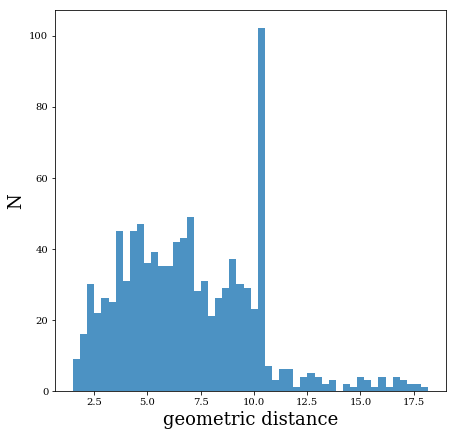

In [22]:
fig,ax = plt.subplots(figsize=(7,7))
ax.set_xlabel('geometric distance',fontsize=18)
ax.set_ylabel('N',fontsize=18)
#ax.axvline(0.0,color='r',linestyle='--',linewidth=3,alpha=0.5)
ax.hist(m_2,bins=50,alpha=0.8)
plt.savefig('abc_part2.pdf')

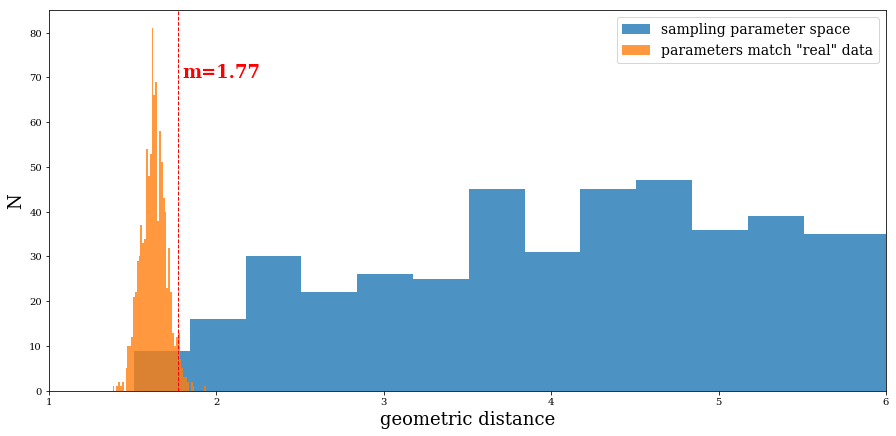

In [31]:
fig,ax = plt.subplots(figsize=(15,7))
ax.set_xlabel('geometric distance',fontsize=18)
ax.set_ylabel('N',fontsize=18)
ax.set_ylim(0,85)
ax.set_xlim(1,6)
ax.axvline(1.77,color='r',linestyle='--',linewidth=1)
ax.text(1.8,70,'m=1.77',fontsize=18,color='r',weight='bold')
ax.hist(m_2,bins=50,alpha=0.8,label='sampling parameter space')
ax.hist(m,bins=50,alpha=0.8,label='parameters match "real" data')
ax.legend(fontsize=14)
plt.savefig('abc_part2_combo.pdf')

In [9]:
!rm part2_fake_data.txt
data.write('part2_fake_data.txt',format='ascii')

# Distance metric: geometric distance $m_{threshold}<1.77$

### Part III

In [19]:
data = Table.read('real_data.fits')

In [20]:
phot_ind = np.random.uniform(0.5,5,1)
obs_time = np.random.randint(10000,100000,1)
alpha_vals = []
obs_vals = []
N = 0
while N < 1000:
    phot_ind = float(np.random.uniform(0.5,5,1))
    obs_time = float(np.random.randint(10000,100000,1))
    bins, nrgy, new_spectrum = simdat.simulate_data(obs_time,phot_ind,'cdf',arf)
    #print new_spectrum
    if geom_dist(np.array(data['Piled']),new_spectrum) < 1.8:
        print geom_dist(np.array(data['Piled']),new_spectrum), phot_ind,obs_time
        spec_col = Column(new_spectrum,name='simspec'+str(N))
        data.add_column(spec_col)
        alpha_vals.append(phot_ind)
        obs_vals.append(obs_time)
        N += 1
    else:
        continue
        
    

1.70720299345 2.76075859786 52196.0
1.75023386342 2.58647465061 49487.0
1.67820392891 2.87722395185 52344.0
1.77736202058 2.61722329697 45700.0
1.58372310571 2.86389282575 52437.0
1.73339569691 2.82113119136 53453.0
1.69223573433 2.74596092658 51960.0
1.64359214219 2.91924159789 48594.0
1.76613657624 3.08222346917 53662.0
1.54256314312 2.90473832845 50851.0
1.74742750234 2.94934030867 51933.0
1.6978484565 2.80200114007 48188.0
1.7165575304 2.94203614324 55748.0
1.73246024322 3.05438653506 52613.0
1.5472404116 2.77247520389 50517.0
1.7736202058 3.00467736337 55109.0
1.73713751169 2.87107110095 51072.0
1.63236669785 2.83666037408 50017.0
1.78203928906 2.69006638281 52905.0
1.56407857811 2.92297886526 51122.0
1.47895229186 2.64890361993 51170.0
1.71000935454 2.93963829936 53513.0
1.72310570627 2.89867429529 51213.0
1.71562207671 3.00040086855 52884.0
1.78858746492 2.77336438033 54047.0
1.7352666043 2.57346186905 51142.0
1.59775491113 2.74511449706 51189.0
1.69504209542 3.00574937355 47963

KeyboardInterrupt: 

In [21]:
data.write('part3_fake_data.txt',format='ascii')

In [22]:
alpha_col = Column(np.array(alpha_vals),name='alpha')
obs_col = Column(np.array(obs_vals),name='obs_time')
params = Table([alpha_col,obs_col])
params.write('part3_parameters.txt',format='ascii')

In [11]:
new_spectrum

array([337, 347, 298, ...,   3,   3,   4])

In [23]:
data

Energy,Unpiled,Piled,simspec0,simspec1,simspec2,simspec3,simspec4,simspec5,simspec6,simspec7,simspec8,simspec9,simspec10,simspec11,simspec12,simspec13,simspec14,simspec15,simspec16,simspec17,simspec18,simspec19,simspec20,simspec21,simspec22,simspec23,simspec24,simspec25,simspec26,simspec27,simspec28,simspec29,simspec30,simspec31,simspec32,simspec33,simspec34,simspec35,simspec36,simspec37,simspec38,simspec39,simspec40,simspec41,simspec42,simspec43,simspec44,simspec45,simspec46,simspec47,simspec48,simspec49,simspec50,simspec51,simspec52,simspec53,simspec54,simspec55,simspec56,simspec57,simspec58,simspec59,simspec60,simspec61,simspec62,simspec63,simspec64,simspec65,simspec66,simspec67,simspec68,simspec69,simspec70,simspec71,simspec72,simspec73,simspec74,simspec75,simspec76,simspec77,simspec78,simspec79,simspec80,simspec81,simspec82,simspec83,simspec84,simspec85,simspec86,simspec87,simspec88,simspec89
float32,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64
0.32,369,263,252,250,266,259,262,274,281,253,275,244,258,230,263,273,246,292,272,263,265,258,269,270,285,290,290,260,268,259,288,255,244,263,272,304,257,276,224,265,249,252,279,286,270,278,269,213,260,275,280,292,278,280,285,273,221,277,240,260,260,278,278,252,281,244,297,251,261,266,226,255,287,227,269,244,235,270,291,262,291,251,231,279,227,236,269,248,253,247,265,253
0.33,383,249,259,265,281,230,263,238,262,249,277,264,250,274,294,283,259,293,262,258,281,248,243,249,235,269,281,291,252,244,269,263,256,245,275,280,250,279,256,286,238,262,246,269,242,252,248,248,216,270,267,267,282,254,265,279,250,269,237,285,252,247,264,282,240,250,252,235,232,260,265,273,261,241,249,247,278,253,268,313,241,271,270,260,255,268,268,244,249,272,250,260
0.34,316,236,263,249,280,232,295,281,255,262,254,236,267,249,266,244,253,289,258,270,272,230,237,276,284,267,282,248,262,234,266,236,241,207,278,266,248,241,239,296,293,253,248,290,290,254,222,238,222,273,253,259,271,264,265,263,265,276,216,226,231,287,248,261,292,272,308,245,265,245,236,248,266,262,268,280,232,258,265,283,266,265,219,265,240,262,273,247,244,255,265,235
0.35,321,286,256,219,255,240,244,254,237,265,246,279,264,240,277,250,262,276,273,299,249,247,296,255,253,273,271,245,248,236,255,251,254,242,256,245,284,235,271,263,233,231,255,263,245,267,232,252,234,266,287,269,271,250,273,255,228,272,252,224,214,260,250,264,289,252,250,210,253,248,260,272,258,221,237,235,252,253,262,286,240,252,224,257,249,241,232,245,252,259,228,232
0.36,268,222,255,243,283,221,238,270,259,243,267,235,211,227,284,274,227,302,254,232,228,239,236,284,259,281,264,255,235,229,252,211,218,249,251,278,246,224,256,262,256,264,269,252,279,265,259,231,249,254,233,285,252,225,282,240,247,277,217,237,251,238,266,228,284,239,268,256,291,232,263,261,258,236,263,253,265,265,245,284,268,261,210,235,225,275,260,228,248,217,210,224
0.37,256,240,221,243,245,215,261,244,245,228,249,258,238,224,292,248,221,263,238,252,242,249,268,254,215,264,276,247,209,246,243,230,239,225,264,256,252,218,216,247,208,244,271,245,241,242,227,198,231,254,263,245,235,245,245,244,240,275,216,226,222,253,252,238,257,246,231,219,244,210,267,260,265,213,265,233,254,224,227,275,252,234,253,223,241,231,217,233,211,231,254,263
0.38,219,196,230,217,272,190,250,240,276,231,238,253,237,217,251,235,242,257,238,227,226,223,216,218,250,229,258,234,222,215,245,227,203,240,292,228,259,219,210,265,236,241,208,275,241,237,222,207,230,243,229,257,257,245,252,231,209,243,260,232,214,251,273,249,236,221,218,237,250,246,210,22

In [33]:
params = Table.read('part3_parameters.txt',format='ascii')

In [34]:
params[:3]

alpha,obs_time
float64,float64
2.76075859786,52196.0
2.58647465061,49487.0
2.87722395185,52344.0


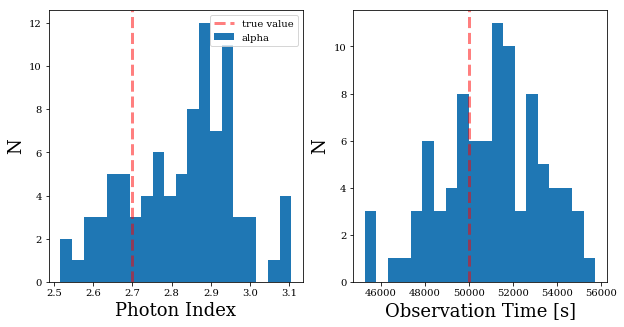

In [47]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(10,5))
p1 = ax[0].hist(params['alpha'],bins=20)
p2 = ax[0].axvline(2.7,color='r',linestyle='--',linewidth=3,alpha=0.5,label='true value')
ax[0].set_xlabel('Photon Index',fontsize=18)
ax[0].set_ylabel('N',fontsize=18)

q1 = ax[1].hist(params['obs_time'],bins=20)
q2 = ax[1].axvline(50000,color='r',linestyle='--',linewidth=3,alpha=0.5)
ax[1].set_xlabel('Observation Time [s]',fontsize=18)
ax[1].set_ylabel('N',fontsize=18)

ax[0].legend(loc=1)